<a href="https://colab.research.google.com/github/luisdzanetta/portfolio_projetos/blob/main/Projeto_1_Teste_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projeto Teste A/B - Qui-Quadrado**

##**Set Up do Exprimento**

####**Dados**
[Kaggle - A/B testing Dataset](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?resource=download)

####**Cenário**
Faremos um teste A/B para uma empresa hipótetica que está tentando aumentar as vendas de um **produto XY** na loja online (e-commerce).

####**Objetivo**
O Objetivo de executar um teste A/B, é avaliar se determinada alteração na página de venda levará a um mlehor desempenho em uma métrica específica.

####**Métricas**
A taxa de **conversão atual é de 13%** (Página A). Ou seja, a cada 100 pessoas que entram na página, 13 compram o **produto XY**. Para esse exemplo, queremos confirmar que as alterações feitas na página de vendas (Página B) resultarão em um aumento de, pelo menos, **2%** na conversão.

####**Hipóteses**
Considerando que a página A é a utilizada atualmente, ou seja, com conversão de 13%. E a página B, é a página com alterações e que será testada:

$H_0$: Não há associação entre a página e taxa de conversão

$H_1$: Há associação entre a página e taxa de conversão

---

####**Amostra**
A amostra necessária para observar o efeito solicitado foi calculada por meio da biblioteca [pingouin](https://pingouin-stats.org/index.html) e do software G * Power v.3.1.9.7 (G * Power, 2021; Bartlett, 2022), considerando os seguintes parâmetros (input Parameters):

**Família do teste (Test family):** Χ² tests

**Teste Estatístico (Statistic test):** Goodness-of-fit testes: Contingency tables

**Tamanho de efeito (Effect size d):** 0,02

**Alpha (α):** 0,05

**Poder (Power) (1-β):** 0,95

**Graus de Liberdade (Degree of Freedom):** ${DF} = {(r-1)} * {(c-1)}$

DF = Degree of Fredom;
r = Number of rows;
c = Number of columns



##**Bibliotecas**

In [ ]:
#Bibliotecas
import pandas as pd
! pip install pingouin
import pingouin as pg
from pingouin import power_chi2

##**Cálculo amostral**

In [ ]:
#Cálculo amostral utilizando a função power_ttest da biblioteca pingouin

print('n: %.4f' % power_chi2(dof=3, w=0.3, power=0.80))

sample_size = power_chi2(dof=1,
                          w=0.02,
                          power = 0.95,
                          alpha = 0.05)

print('Amostra por grupo = %.f' %sample_size)
print('Amostra total = %.f' %(sample_size*2))

n: 121.1396
Amostra por grupo = 32487
Amostra total = 64974


Cálculo amostral via G * Power

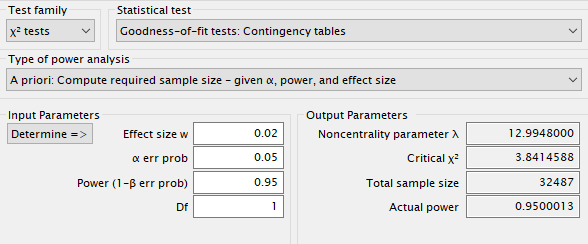

##**Base de Dados**

In [ ]:
#Carregar BD
from google.colab import files
uploaded = files.upload()

In [ ]:
df_raw = pd.read_csv('Projeto#1_Teste_AB.csv')

In [ ]:
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##**Análise Descritiva**

In [ ]:
#Número de linhas e de colunas do df
print('Número de linhas: %.f' %df_raw.shape[0])
print('Número de colunas: %.f' %df_raw.shape[1])

Número de linhas: 294478
Número de colunas: 5


In [ ]:
#Check: NA
df_raw.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [ ]:
#Check1: control = old_page & treatment = new_page
df_raw[['user_id',
        'group',
        'landing_page']].groupby(['group',
                                  'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [ ]:
#Identificar valores que estão duplicados, ou seja, em ambos os grupos
df_user_delete = df_raw[['user_id',
                         'group',
                         'landing_page']].groupby(['user_id']).count().reset_index().query('group > 1')
print('O número de usuários duplicados é: %.f' %df_user_delete.shape[0])

O número de usuários duplicados é: 3894


In [ ]:
#Deletar usuários duplicados
df1 = df_raw.drop_duplicates('user_id', keep=False)
print('O número de usuários após deletar os user_id duplicados é: %.f' %df1.shape[0])

O número de usuários após deletar os user_id duplicados é: 286690


In [ ]:
#Check2: control = old_page & treatment = new_page
df1[['user_id',
        'group',
        'landing_page']].groupby(['group',
                                  'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


##**Amostragem**

In [ ]:
#Grupo Controle (A)
df_gc = df1[df1['group'] == 'control'].sample(n=int(sample_size), random_state = 42)
print('N Grupo Controle = %.f' %df_gc.shape[0])

#Grupo Tratamento (B)
df_gt = df1[df1['group'] == 'treatment'].sample(n=int(sample_size), random_state = 42)
print('N Grupo Tratamento = %.f' %df_gt.shape[0])

#Concatenar os grupos em um df
df_ab = pd.concat([df_gc, df_gt]).reset_index(drop = True)
print('N df_ab = %.f' %df_ab.shape[0])

N Grupo Controle = 32486
N Grupo Tratamento = 32486
N df_ab = 64972


##**Cálculo da conversão das páginas**

${Conversão} = \frac{Clientes}{Visitantes}$

In [ ]:
#Conversão página A - Controle
clientes_gc = df_gc.loc[df_gc['converted'] == 1, 'converted'].sum()
visitantes_gc = df_gc.shape[0]
conversao_gc = clientes_gc / visitantes_gc

print('A taxa de conversão da página A foi de {:.2f}%' .format(conversao_gc*100))

#Conversão página B - Tratamento
clientes_gt = df_gt.loc[df_gt['converted'] == 1, 'converted'].sum()
visitantes_gt = df_gt.shape[0]
conversao_gt = clientes_gt / visitantes_gt

print('A taxa de conversao da página B foi de {:.2f}%' .format(conversao_gt*100))

A taxa de conversão da página A foi de 11.72%
A taxa de conversao da página B foi de 11.76%


##**Teste Estatístico**

Definição: A statistic having, at least approximately, a chi-squared distribution. An example is the test statistic used to assess the independence :of the two variables forming a contingency table where Oi represents an observed frequency and Ei the expected frequency under independence. Under the hypothesis of independence χ2 has, approximately, a chi-squared distribution with (r−1)(c−1) degrees of freedom [(Everitt & Skrondal, 2010)](http://www.stewartschultz.com/statistics/books/Cambridge%20Dictionary%20Statistics%204th.pdf).

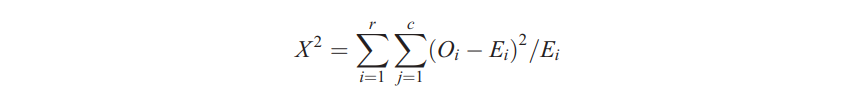


In [ ]:
#Qui-Quadrado (Chi-sqaured [χ2])

expected, observed, stats = pg.chi2_independence(df_ab, x='group',
                                                 y='converted')


In [ ]:
#Valores esperados

expected

converted,0,1
group,,
control,28672.0,3814.0
treatment,28672.0,3814.0


In [ ]:
#Valores observados

observed

converted,0,1
group,,
control,28677.5,3808.5
treatment,28666.5,3819.5


The test summary columns [(Vallat, 2022)](https://pingouin-stats.org/generated/pingouin.chi2_independence.html#pingouin.chi2_independence):

* test: The statistic name

* lambda: The λ value used for the power divergence statistic

* chi2: The test statistic

* pval: The p-value of the test

* cramer: The Cramer’s V effect size

* power: The statistical power of the test


In [ ]:
#Estatísitcas do Teste
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,0.018,1.0,0.893,0.001,0.052
1,cressie-read,0.667,0.018,1.0,0.893,0.001,0.052
2,log-likelihood,0.000,0.018,1.0,0.893,0.001,0.052
3,freeman-tukey,-0.500,0.018,1.0,0.893,0.001,0.052
4,mod-log-likelihood,-1.000,0.018,1.0,0.893,0.001,0.052
5,neyman,-2.000,0.018,1.0,0.893,0.001,0.052


##**Resultados**

Foi realizado um teste de qui-quadrado de independência (2x2) com objetivo de investigar se havia associação entre a conversão (sim e não) e o a página de venda (página A e página B). Não foi encontrada associação significativa entre a página e a conversão (χ2(1) = 0,018, p = 0,893).